In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
N = 10000
SMEAR = 0.3
bins = [-np.inf, -3.5, -2, -1, -0.5, 0, 0.5, 1, 2, 3.5, np.inf]
truth_data = np.random.normal(size=N)
truth_hist, _ = np.histogram(truth_data, bins=bins)
resolution = np.random.normal(loc=1., scale=SMEAR, size=N)
efficiency = np.random.uniform(size=N) > 0.
observed_data = (resolution * truth_data)[efficiency]
observed_hist, _ = np.histogram(observed_data, bins=bins)
migrations, _, _ = np.histogram2d(observed_data, truth_data[efficiency], bins=bins)
response = migrations / truth_hist

In [3]:
truth_hist

array([   1,  215, 1401, 1437, 1982, 1858, 1519, 1366,  218,    3])

In [4]:
observed_hist

array([  18,  284, 1237, 1399, 2098, 2010, 1470, 1177,  291,   16])

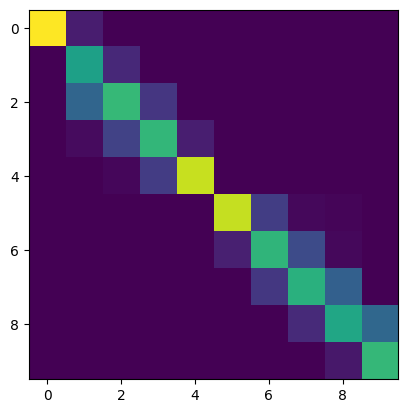

In [5]:
plt.imshow(response)

In [6]:
# test closure
np.testing.assert_almost_equal(np.dot(response, truth_hist), observed_hist)

In [ ]:
model = pm.Model()

with model:
    params = pm.DiscreteUniform(
        "params", 
        lower=truth_hist // 10, 
        upper=truth_hist * 10,
    )
    likelihood = pm.Poisson(
        "likelihood", mu=pm.math.dot(response, params),
        observed=observed_hist,
    )
    trace = pm.sample(draws=50000, tune=10000)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

In [ ]:
positions = [-4.5, -2.75, -1.5, -0.75, -0.25, 0.25, 0.75, 1.5, 2.75, 4.5]
xerr = [1, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.75, 1]
vp = plt.violinplot(
    trace.posterior.params[0],
    positions=positions,
    showextrema=False,
)
eb = plt.errorbar(
    x=positions,
    y=truth_hist,
    xerr=xerr,
    fmt=".",
)
plt.legend([vp["bodies"][0], eb.lines], ["Posterior", "Truth"])